In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

In [ ]:
def tune_params(train_X, train_Y, test_X, test_Y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, show_plots=True):

    b_par={} #A void dictionary which will contain the best params in each iteration

    #TUNING TREES
    #INTIAL MODEL
    model=xgb.XGBClassifier(objective='binary:logistic',
                        learning_rate=0.2,
                        max_depth=7,
                        min_child_weight=5,
                        reg_lambda=1010,
                        n_estimators=150)

    #NUMBER OF TREES
    eval_set = [(train_X, train_Y), (test_X, test_Y)]
    eval_metric = ["auc","error"]
    %time model.fit(train_X, train_Y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

    # Evaluation results
    evaluation_results = model.evals_result_
    auc_train = evaluation_results["validation_0"]["auc"] # Train ‘auc’ metric
    auc_test  = evaluation_results["validation_1"]["auc"] # Test ‘auc’ metric

    if show_plots:
        # Plotting ‘XGBOOST Classification Error’ and ‘XGBOOST Classification AUC’
        plt.figure(figsize=(7,7))
        plt.plot(auc_train)
        plt.plot(auc_test)
        plt.xlabel('Number of trees (n_estimators)')
        plt.ylabel('auc')
        plt.legend(['Train', 'Test'])
        plt.title('XGBoost Classification AUC')
        plt.show()

    param_test1 = {
             'n_estimators':[100,150,200,250]
            }

    gsearch1 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2,
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010),

                                     param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

    gsearch1.fit(train_X,train_Y)

    b_par['n_estimators']=gsearch1.best_params_['n_estimators']

    #DEPTH AND WEIGHT TUNING
    v1=0

    param_test2 = {
             'max_depth':[5,6,7],
             'min_child_weight':[4,5,6]
            }

    gsearch2 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2,
                                                              n_estimators=b_par['n_estimators'],
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010),

                                     param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

    gsearch2.fit(train_X,train_Y)
    #gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_
    v1+=1

    while gsearch2.best_score_ < gsearch1.best_score_ and v1!=3:

        param_test2 = {
             'max_depth':[5,6,7],
             'min_child_weight':[4,5,6]
            }

        gsearch2 = GridSearchCV(estimator = XGBClassifier( objective= 'binary:logistic',
                                                              learning_rate=0.2,
                                                              n_estimators=b_par['n_estimators'] ,
                                                              max_depth=6,
                                                              min_child_weight=2,
                                                              reg_lambda=1010),

                                     param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

        gsearch2.fit(train_X,train_Y)
        #gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_
        v1+=1

    if gsearch2.best_score_ < gsearch1.best_score_:
        b_par['max_depth']=6
        b_par['min_child_weight']=1
        gsearch2.best_score_ = gsearch1.best_score_
        print(b_par)
    else:
        b_par['max_depth']= gsearch2.best_params_['max_depth']
        b_par['min_child_weight']= gsearch2.best_params_['min_child_weight']

    #GAMMA TUNING
    v2=0

    param_test3 = {
         'gamma':[0.15, 0.1, 0.05, 0]
        }

    gsearch3 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000
                                                           ),
                                param_grid=param_test3,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch3.fit(train_X,train_Y)
    #gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_
    v2+=1

    while gsearch3.best_score_ < gsearch2.best_score_ and v2!=3:
        param_test3 = {
         'gamma':[0.15, 0.1, 0.05, 0]
        }

        gsearch3 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000
                                                           ),
                                param_grid=param_test3,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch3.fit(train_X,train_Y)
        #gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_
        v2+=1

    if gsearch3.best_score_ < gsearch2.best_score_:
        b_par['gamma']=0
        gsearch3.best_score_ = gsearch2.best_score_
    else:
        b_par['gamma'] = gsearch3.best_params_['gamma']

    #SAMPLES TUNING
    v3=0

    param_test4 = {
         'subsample':[0.825, 0.85, 0.875, 0.9],
         'colsample_bytree':[0.85, 0.875, 0.9]
        }


    gsearch4 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma']
                                                           ),
                                param_grid=param_test4,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch4.fit(train_X,train_Y)
    #gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_
    v3+=1

    while gsearch4.best_score_ < gsearch3.best_score_ and v3!=3:
        param_test4 = {
         'subsample':[0.825, 0.85, 0.875, 0.9],
         'colsample_bytree':[0.85, 0.875, 0.9]
        }


        gsearch4 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma']
                                                           ),
                                param_grid=param_test4,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch4.fit(train_X,train_Y)
        #gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_
        v3+=1

    if gsearch4.best_score_ < gsearch3.best_score_:
        b_par['subsample']=1
        b_par['colsample_bytree']=1
        gsearch4.best_score=gsearch3.best_score_
    else:
        b_par['subsample'] = gsearch4.best_params_['subsample']
        b_par['colsample_bytree'] = gsearch4.best_params_['colsample_bytree']

    #REGULARIZATION TUNING
    v4=0

    param_test6 = {
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'reg_lambda':[200, 300, 400, 500, 600]
        }

    gsearch5 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma'],
                                                            subsample=b_par['subsample'],
                                                            colsample_bytree=b_par['colsample_bytree']
                                                           ),
                                param_grid=param_test6,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

    gsearch5.fit(train_x,train_y)
    #gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_
    v4+=1

    while gsearch5.best_score_ < gsearch4.best_score_ and v4!=3:
        param_test6 = {
         'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
         'reg_lambda':[200, 300, 400, 500, 600]
        }

        gsearch5 = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                            learning_rate=0.2,
                                                            n_estimators=b_par['n_estimators'],
                                                            reg_lambda=1000,
                                                            max_depth=b_par['max_depth'],
                                                            min_child_weight=b_par['min_child_weight'],
                                                            gamma=b_par['gamma'],
                                                            subsample=b_par['subsample'],
                                                            colsample_bytree=b_par['colsample_bytree']
                                                           ),
                                param_grid=param_test6,
                                scoring='roc_auc', verbose=0, n_jobs=10, cv=5)

        gsearch5.fit(train_x,train_y)
        #gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

    if gsearch5.best_score_ < gsearch4.best_score_:
        b_par['reg_alpha']=0
        b_par['reg_lambda']=1
        gsearch5.best_score_=gsearch4.best_score_
    else:
        b_par['reg_alpha'] = gsearch5.best_params_['reg_alpha']
        b_par['reg_lambda']= gsearch5.best_params_['reg_lambda']

    #STUFF
    model = xgb.XGBClassifier(objective="binary:logistic",
                                learning_rate=0.2,
                                n_estimators=b_par['n_estimators'],
                                reg_lambda=b_par['reg_lambda'],
                                reg_alpha=b_par['reg_alpha'],
                                max_depth=b_par['max_depth'],
                                min_child_weight=b_par['min_child_weight'],
                                gamma=b_par['gamma'],
                                subsample=b_par['subsample'],
                                colsample_bytree=b_par['colsample_bytree'])
    model.fit(train_X, train_Y)

    #CALCULATING PROBABILITIES
    predict_signal_test= model.predict_proba(test_signal_x)[:,1] #Probabilities of being signal or background
    predict_signal_train=model.predict_proba(train_signal_x)[:,1] #Double array of probabilities

    predict_bkgnd_test=model.predict_proba(test_bkgnd_x)[:,1]
    predict_bkgnd_train=model.predict_proba(train_bkgnd_x)[:,1]

    #VERIFYING OVERFITTING
    plt.figure(figsize=(10,7))
    plt.title('Signal overfitting')
    m=plt.hist(predict_signal_test, bins=20, label='Test', color='olive')
    n=plt.hist(predict_signal_train, bins=m[1], label='Train', histtype='stepfilled', facecolor='none', edgecolor='red', color='red',
            hatch='///')
    plt.legend(fontsize=13)
    plt.yscale('log')

    if show_plots:
        plt.show()

    #SIGNAL
    chi2_signal=0
    lista=[]

    for i in range(len(m[0])):
        if n[0][i]==0:
            num=0
        else:
            num=((m[0][i]-n[0][i])**2)/n[0][i]
        chi2_signal=chi2_signal+num

    chi2_signal=chi2_signal/20

    #BKGND
    plt.figure(figsize=(10,7))
    plt.title('Background overfitting')
    m2=plt.hist(predict_bkgnd_test, bins=20, label='Test', color='olive')
    n2=plt.hist(predict_bkgnd_train, bins=m2[1], label='Train', histtype='stepfilled', facecolor='none', edgecolor='red', color='red',
            hatch='///')
    plt.legend(fontsize=13)
    plt.yscale('log')

    chi2_bkgnd=0
    for i in range(len(m[0])):
        if n2[0][i]==0:
            num=0
        else:
            num=((m2[0][i]-n2[0][i])**2)/n2[0][i]
        chi2_bkgnd=chi2_bkgnd+num

    chi2_bkgnd=chi2_bkgnd/20

    #ROC CURVE
    plt.figure(figsize=(10,7))
    plt.title('ROC curve', fontsize=13)
    model_predict = model.predict_proba(test_X)
    model_predict = model_predict[:,1]
    auc_score_test = roc_auc_score(test_Y, model_predict)
    fpr, tpr, _ = roc_curve(test_Y, model_predict) #roc_curve(true binary labels, prediction scores)
    print('Test : ', auc_score_test)
    plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score_test, 4)), color='purple')

    model_predict = model.predict_proba(train_X)
    model_predict = model_predict[:,1]
    auc_score_train = roc_auc_score(train_Y, model_predict)
    fpr, tpr, _ = roc_curve(train_Y, model_predict)
    plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score_train, 4)) , color='orange', linewidth=3)
    print('Train : ', auc_score_train)
    plt.legend(fontsize=13)
    plt.ylabel('background rejection', fontsize=13)
    plt.xlabel('Signal efficiency', fontsize=13)
    plt.show()


    #OVERFITTING AND ROC CURVE
    if (chi2_signal <= 100 and auc_score_train >=0.90):
        print(b_par)
    else:
        print("You should consider repeating this procedure.")
        print(b_par)

    return b_par

In [ ]:
signal = pd.read_pickle('Signal_5.pkl')
bkgnd = pd.read_pickle('Right_5.pkl') #sometimes we also use csv (comma separated value) files

signal.head()

,event,luminosityBlock,run,Bpt,PDL,prob,BMass,cosThetaKMu,DiMuMass,errDiMuMass,DiMupt,kpt,fit_k_phi,fit_k_eta,k_charge,k_nValidHits,k_lostInnerHits,k_matchLooseMuon,k_matchMediumMuon,k_matchMuon,k_matchSoftMuon,l1pt,l2pt,fit_l1_eta,fit_l2_eta,fit_l1_phi,fit_l2_phi,l1_charge,l2_charge,cosA,signLxy,Mu1_isTriggering,Mu2_isTriggering,Mu1_nPixelHits,Mu2_nPixelHits,Mu1_nPixelLayers,Mu2_nPixelLayers,Mu1_nTrackerLayers,Mu2_nTrackerLayers,Mu1_nValidHits,Mu2_nValidHits,HLT_Mu7_IP4,HLT_Mu8_IP6,HLT_Mu8_IP5,HLT_Mu8_IP3,HLT_Mu8p5_IP3p5,HLT_Mu9_IP6,HLT_Mu9_IP5,HLT_Mu9_IP4,HLT_Mu10p5_IP3p5,HLT_Mu12_IP6,L1_SingleMu7er1p5,L1_SingleMu8er1p5,L1_SingleMu9er1p5,L1_SingleMu10er1p5,L1_SingleMu12er1p5,L1_SingleMu22,GENCand
15527,2909917,29100,1,53.841000,0.014012,0.983293,5.323006,0.309423,2.639465,0.017254,28.510771,25.405861,-3.068242,0.584886,1.0,20.0,1,0,0,1,1,14.772147,13.756947,0.761223,0.591365,-3.139777,3.071678,1.0,-1.0,0.999971,13.537466,0,1,4,4,4,4,13,14,16,19,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,0,True
28009,3934323,39344,1,13.345943,0.137219,0.574510,5.256719,-0.054099,3.920489,0.032115,8.845884,4.629198,2.865229,-0.599570,1.0,20.0,-1,0,0,0,0,7.216099,1.658096,-0.290224,-1.352398,2.611550,2.406427,1.0,-1.0,0.999972,55.685097,1,0,3,4,3,4,12,12,15,15,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,True
19944,3378576,33786,1,19.678831,0.037034,0.233425,5.308390,-0.019637,2.072200,0.015318,19.491831,0.555084,1.637971,-0.412408,1.0,6.0,-1,0,0,0,0,10.541368,9.058259,0.002276,0.021805,2.781297,2.991759,1.0,-1.0,0.998683,14.410810,0,1,0,3,0,2,10,12,14,18,1,0,1,1,0,0,1,1,0,0,1,1,1,1,0,0,True
26067,3730809,37309,1,14.061918,0.061186,0.400541,5.292941,-0.256351,4.483814,0.026378,13.358907,0.732978,2.995958,-0.568555,-1.0,14.0,-1,0,0,0,0,8.949202,4.903897,0.000867,-0.385534,3.094024,-2.628277,1.0,-1.0,0.999949,28.952126,1,0,4,4,4,4,14,14,18,18,1,1,1,1,0,0,0,0,0,0,1,1,1,0,0,0,True
36365,4854379,48544,1,20.260057,0.009491,0.679047,5.268119,0.262336,1.053862,0.006376,17.468430,3.265634,-0.427496,-0.961146,1.0,13.0,-1,0,0,0,0,9.586935,7.901750,-0.615594,-0.684035,0.208453,0.111734,1.0,-1.0,0.999505,5.974150,1,0,4,4,4,4,14,14,18,18,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,True


In [ ]:
xgb.__version__

'0.90'

In [ ]:
#Useful columns or features
signal = signal[['Bpt' ,'PDL' ,'prob' , 'kpt', 'cosA' ,'signLxy']]
bkgnd = bkgnd[['Bpt' ,'PDL' ,'prob' , 'kpt', 'cosA' ,'signLxy']]

#Labels
bkgnd['signal/bkgnd'] = 0
signal['signal/bkgnd'] = 1

df = pd.concat([signal,bkgnd])

df.head()
#df.info()

,Bpt,PDL,prob,kpt,cosA,signLxy,signal/bkgnd
15527,53.841000,0.014012,0.983293,25.405861,0.999971,13.537466,1
28009,13.345943,0.137219,0.574510,4.629198,0.999972,55.685097,1
19944,19.678831,0.037034,0.233425,0.555084,0.998683,14.410810,1
26067,14.061918,0.061186,0.400541,0.732978,0.999949,28.952126,1
36365,20.260057,0.009491,0.679047,3.265634,0.999505,5.974150,1


In [ ]:
#SIGNAL
signal_x=signal.drop(['signal/bkgnd'], axis=1)
signal_y=signal['signal/bkgnd']

#BKGND
bkgnd_x=bkgnd.drop(['signal/bkgnd'], axis=1)
bkgnd_y=bkgnd['signal/bkgnd']

#GENERAL
test_x=df.drop(['signal/bkgnd'], axis=1)
test_y=df['signal/bkgnd']

#SIGNAL
train_signal_x, test_signal_x, train_signal_y, test_signal_y= train_test_split(signal_x, signal_y,
                                                                              test_size=0.5,
                                                                              random_state=1)

#BKGND
train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y= train_test_split(bkgnd_x, bkgnd_y,
                                                                          test_size=0.5,
                                                                          random_state=1)

#GENERAL
train_x=train_signal_x.append(train_bkgnd_x) #There's no need to construct again the sets cause we have already defined its components
test_x= test_signal_x.append(test_bkgnd_x)

train_y=train_signal_y.append(train_bkgnd_y)
test_y=test_signal_y.append(test_bkgnd_y)

[0]	validation_0-auc:0.933677	validation_0-error:0.0432	validation_1-auc:0.936851	validation_1-error:0.0444
[1]	validation_0-auc:0.933574	validation_0-error:0.0462	validation_1-auc:0.937106	validation_1-error:0.0454
[2]	validation_0-auc:0.934084	validation_0-error:0.046	validation_1-auc:0.937658	validation_1-error:0.0448
[3]	validation_0-auc:0.934248	validation_0-error:0.045	validation_1-auc:0.937958	validation_1-error:0.0434
[4]	validation_0-auc:0.939698	validation_0-error:0.0446	validation_1-auc:0.941771	validation_1-error:0.0434
[5]	validation_0-auc:0.941581	validation_0-error:0.0442	validation_1-auc:0.944031	validation_1-error:0.043
[6]	validation_0-auc:0.943925	validation_0-error:0.0456	validation_1-auc:0.947358	validation_1-error:0.0454
[7]	validation_0-auc:0.949394	validation_0-error:0.0464	validation_1-auc:0.951157	validation_1-error:0.046
[8]	validation_0-auc:0.94966	validation_0-error:0.046	validation_1-auc:0.95139	validation_1-error:0.0456
[9]	validation_0-auc:0.958784	valid

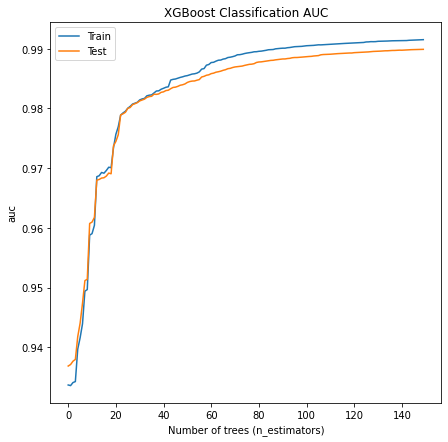

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


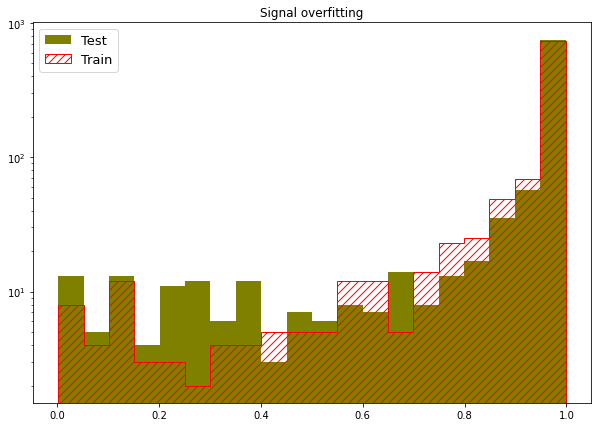

Test :  0.9942540000000001
Train :  0.99705625


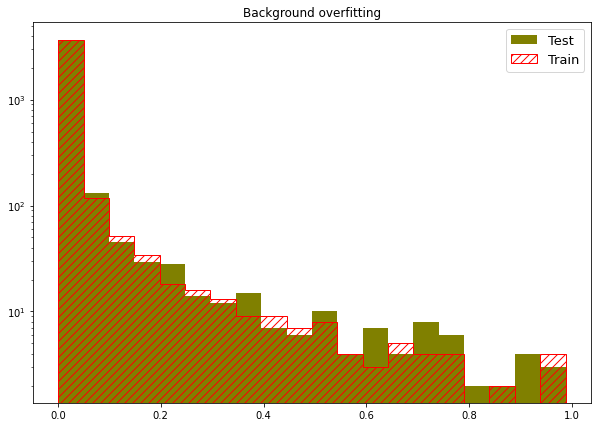

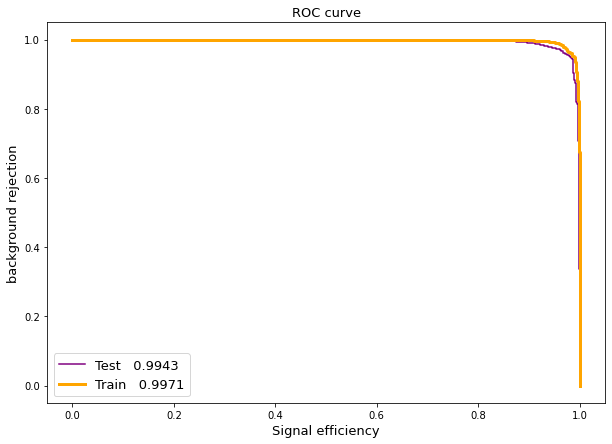

{'n_estimators': 250, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0, 'subsample': 0.9, 'colsample_bytree': 0.85, 'reg_alpha': 0.1, 'reg_lambda': 200}


In [ ]:
par = tune_params(train_x, train_y, test_x, test_y, test_signal_x, train_signal_x, test_bkgnd_x, train_bkgnd_x, True)

In [ ]:
par

{'colsample_bytree': 0.85,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 250,
 'reg_alpha': 0.1,
 'reg_lambda': 200,
 'subsample': 0.9}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model = xgb.XGBClassifier(objective="binary:logistic",
                                learning_rate=0.2,
                                n_estimators=par['n_estimators'],
                                reg_lambda=par['reg_lambda'],
                                reg_alpha=par['reg_alpha'],
                                max_depth=par['max_depth'],
                                min_child_weight=par['min_child_weight'],
                                gamma=par['gamma'],
                                subsample=par['subsample'],
                                colsample_bytree=par['colsample_bytree'])

model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.85, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=200, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [ ]:
predict_signal = model.predict(test_x)
print(np.round(accuracy_score(test_y,predict_signal)*100, 2),'%') #97.75%

97.3 %


In [ ]:
import pickle
import json

pickle.dump(model, open("model_rightSB2.pickle.dat", "wb"))

In [ ]:
#applying the model to test and training
predict_signal_test =  model.predict_proba(test_signal_x)[:,1]
predict_signal_train =  model.predict_proba(train_signal_x)[:,1]

predict_back_test = model.predict_proba(test_bkgnd_x)[:,1]
predict_back_train = model.predict_proba(train_bkgnd_x)[:,1]

**Overfitting**

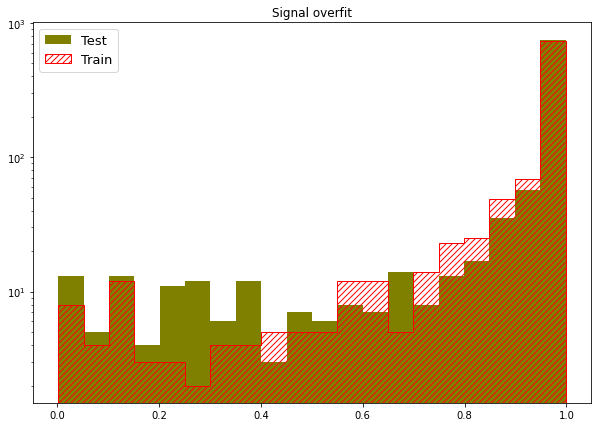

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Signal overfit')
m = plt.hist(predict_signal_test, bins=20, label='Test', color='olive')
plt.hist(predict_signal_train, bins=m[1], label='Train',
         histtype='stepfilled', facecolor='none', edgecolor='red',
        hatch='////')
plt.legend(fontsize=13)
plt.yscale('log')
plt.show()

In [ ]:
from scipy import stats

stats.ks_2samp(predict_signal_test, predict_signal_train)

Ks_2sampResult(statistic=0.038, pvalue=0.4659595288557257)

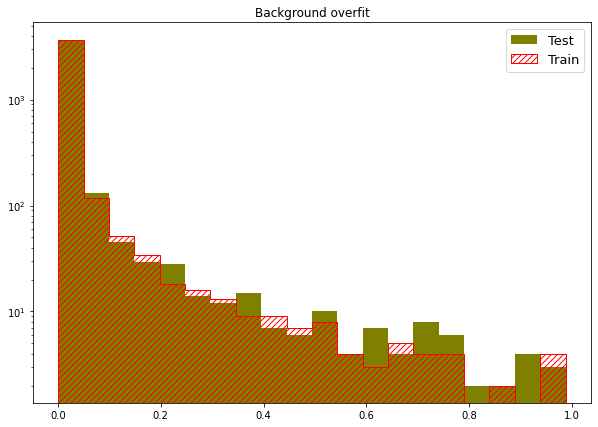

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Background overfit')
m = plt.hist(predict_back_test, bins=20, label='Test', color='olive',)
plt.hist(predict_back_train, bins=m[1], label='Train',
         histtype='stepfilled', facecolor='none', edgecolor='red',
        hatch='////')
plt.legend(fontsize=13)
plt.yscale('log')
plt.show()

In [ ]:
from scipy import stats

stats.ks_2samp(predict_back_test, predict_back_train)

Ks_2sampResult(statistic=0.02575, pvalue=0.1409410523926459)

Test :  0.9942540000000001
Train :  0.99705625


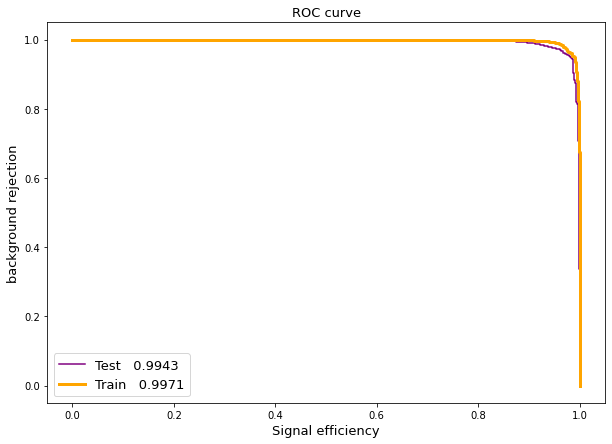

In [ ]:
plt.figure(figsize=(10,7))
plt.title('ROC curve', fontsize=13)
model_predict = model.predict_proba(test_x)
model_predict = model_predict[:,1]
auc_score_test = roc_auc_score(test_y, model_predict)
fpr, tpr, _ = roc_curve(test_y, model_predict) #roc_curve(true binary labels, prediction scores)
print('Test : ', auc_score_test)
plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score_test, 4)), color='purple')

model_predict = model.predict_proba(train_x)
model_predict = model_predict[:,1]
auc_score_train = roc_auc_score(train_y, model_predict)
fpr, tpr, _ = roc_curve(train_y, model_predict)
plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score_train,4)) , color='orange', linewidth=3)
print('Train : ', auc_score_train)
plt.legend(fontsize=13)

plt.ylabel('background rejection', fontsize=13)
plt.xlabel('Signal efficiency', fontsize=13)
plt.show()